In [1]:
import pandas as pd

# Load CSV exported from Google Trends
df_raw = pd.read_csv("multiTimeline.csv", skiprows=2)
df_raw.columns = ["date", "internship"]
df_raw["date"] = pd.to_datetime(df_raw["date"], format="%Y-%m")
df_raw["internship"] = df_raw["internship"].replace("<1", 0).astype(int)

df_raw.head()

,date,internship
0,2004-01-01,73
1,2004-02-01,70
2,2004-03-01,66
3,2004-04-01,57
4,2004-05-01,41


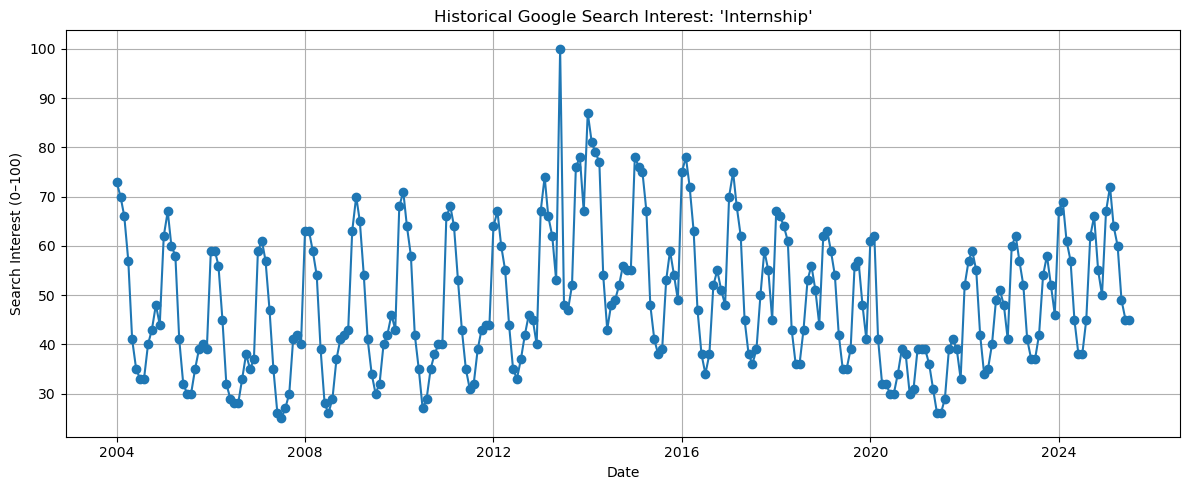

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(df_raw["date"], df_raw["internship"], marker='o')
plt.title("Historical Google Search Interest: 'Internship'")
plt.xlabel("Date")
plt.ylabel("Search Interest (0–100)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [3]:
from prophet import Prophet

df = df_raw.rename(columns={"date": "ds", "internship": "y"})
model = Prophet()
model.fit(df)

last_date = pd.to_datetime("2026-08-31")
current_max = df["ds"].max()
months_to_add = ((last_date.year - current_max.year) * 12 +
                 (last_date.month - current_max.month))

future = model.make_future_dataframe(periods=months_to_add, freq='ME')
forecast = model.predict(future)

# Aug 2025 – Aug 2026
forecast_range = forecast[(forecast["ds"] >= "2025-08-01") & (forecast["ds"] <= "2026-08-31")]
forecast_range[["ds", "yhat", "yhat_lower", "yhat_upper"]].head()

17:42:19 - cmdstanpy - INFO - Chain [1] start processing
17:42:19 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper
260,2025-08-31,48.857368,39.433952,58.187110
261,2025-09-30,53.706999,44.462378,63.267372
262,2025-10-31,49.739744,40.865627,59.343335
263,2025-11-30,45.120121,35.587038,54.086041
264,2025-12-31,71.731443,62.559011,81.162084


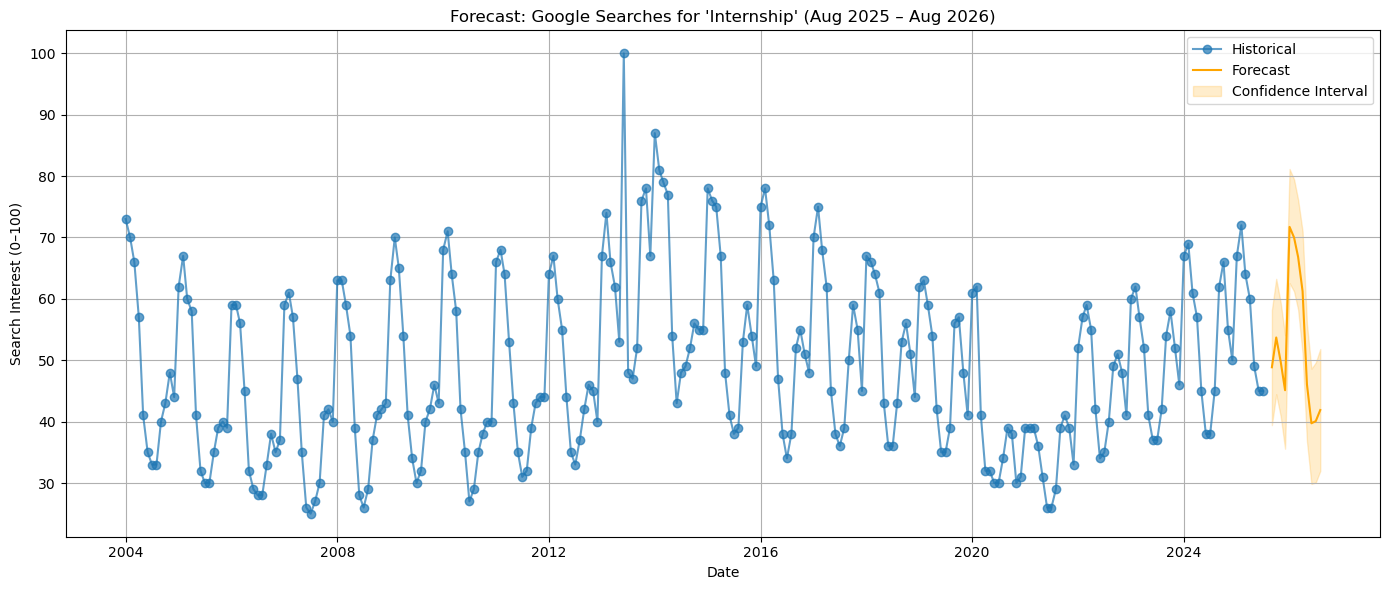

In [4]:
plt.figure(figsize=(14, 6))
plt.plot(df["ds"], df["y"], label="Historical", marker='o', alpha=0.7)
plt.plot(forecast_range["ds"], forecast_range["yhat"], label="Forecast", color='orange')
plt.fill_between(forecast_range["ds"],
                 forecast_range["yhat_lower"],
                 forecast_range["yhat_upper"],
                 color='orange', alpha=0.2, label="Confidence Interval")
plt.title("Forecast: Google Searches for 'Internship' (Aug 2025 – Aug 2026)")
plt.xlabel("Date")
plt.ylabel("Search Interest (0–100)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

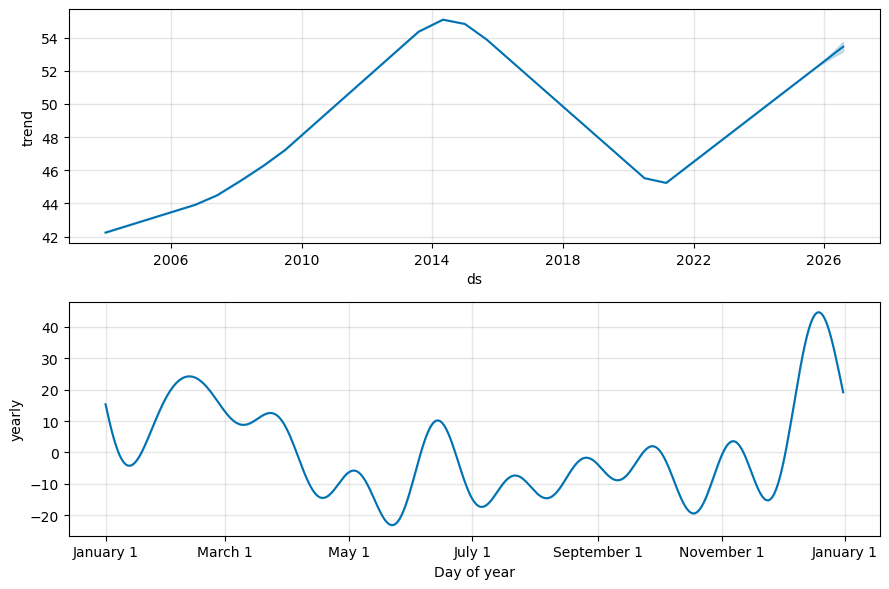

In [5]:
model.plot_components(forecast)
plt.tight_layout()
plt.show()

In [6]:
df_raw['MonthName'] = df_raw['date'].dt.strftime('%B')
monthly_avg = df_raw.groupby('MonthName')['internship'].mean()

In [7]:
df_raw['MonthName'] = df_raw['date'].dt.strftime('%B')
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']

In [8]:
monthly_avg = df_raw.groupby('MonthName')['internship'].mean().reindex(month_order)

In [9]:
import numpy as np
from scipy.interpolate import make_interp_spline

x = np.arange(len(monthly_avg))  # 0 to 11 for months
y = monthly_avg.values

# Create smooth spline curve
xnew = np.linspace(x.min(), x.max(), 100)  # 100 points for smoothness
spl = make_interp_spline(x, y, k=3)       # cubic spline
y_smooth = spl(xnew)

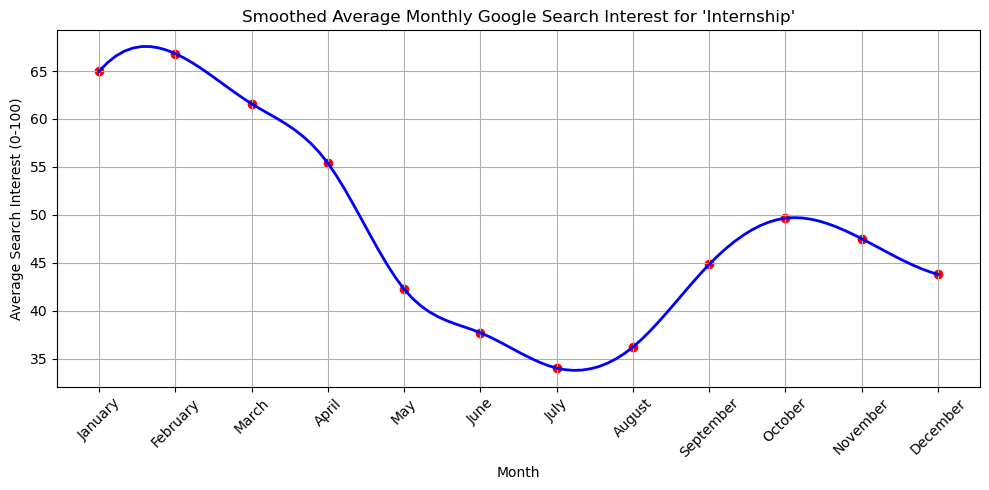

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(xnew, y_smooth, color='blue', linewidth=2)
plt.scatter(x, y, color='red')  # actual data points
plt.xticks(x, month_order, rotation=45)
plt.title("Smoothed Average Monthly Google Search Interest for 'Internship'")
plt.xlabel("Month")
plt.ylabel("Average Search Interest (0-100)")
plt.grid(True)
plt.tight_layout()
plt.show()

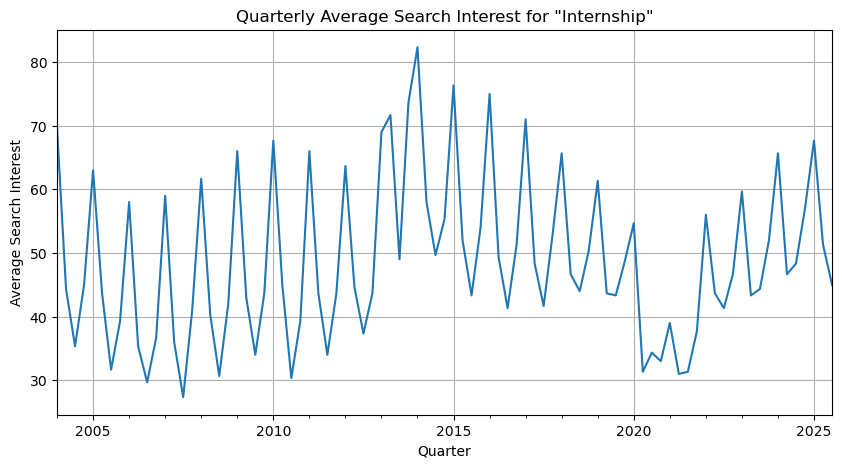

In [11]:
df_raw['Quarter'] = df_raw['date'].dt.to_period('Q')
quarterly_avg = df_raw.groupby('Quarter')['internship'].mean()

plt.figure(figsize=(10,5))
quarterly_avg.plot()
plt.title('Quarterly Average Search Interest for "Internship"')
plt.xlabel('Quarter')
plt.ylabel('Average Search Interest')
plt.grid(True)
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
df = df_raw.rename(columns={"date": "ds", "internship": "y"})

# Split data: 80% train, 20% test (by time)
split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# Fit Prophet on training data
model = Prophet()
model.fit(train)

# Create dataframe for forecasting the test period
future = model.make_future_dataframe(periods=len(test), freq='MS')  # MS = month start freq
forecast = model.predict(future)

forecast_test = forecast.iloc[-len(test):][['ds', 'yhat']].reset_index(drop=True)

comparison = test.reset_index(drop=True).copy()
comparison['yhat'] = forecast_test['yhat']

mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))

print(f"MAE on test set: {mae:.3f}")
print(f"RMSE on test set: {rmse:.3f}")

17:42:22 - cmdstanpy - INFO - Chain [1] start processing
17:42:22 - cmdstanpy - INFO - Chain [1] done processing


MAE on test set: 17.501
RMSE on test set: 20.250


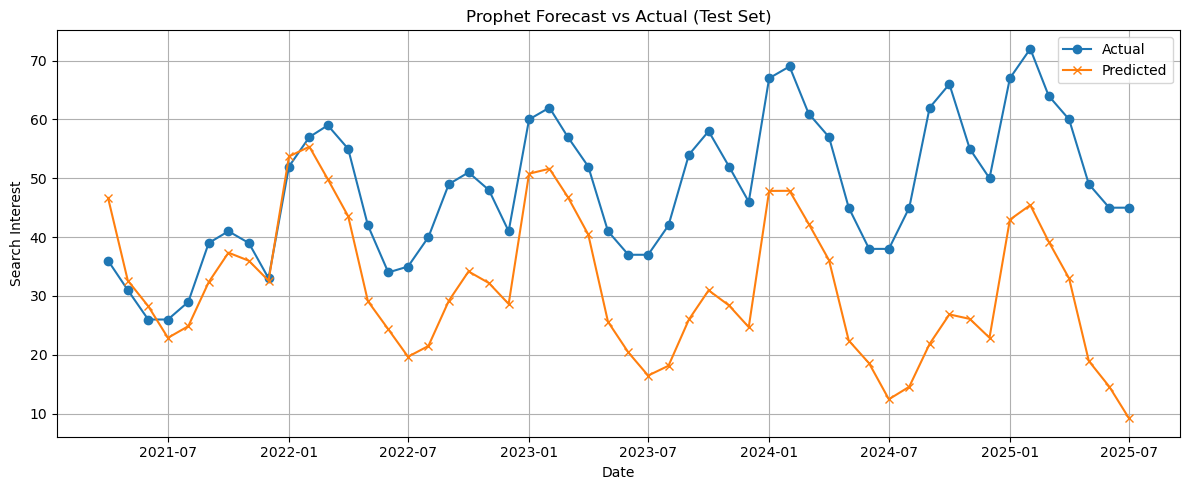

In [13]:
plt.figure(figsize=(12, 5))
plt.plot(comparison['ds'], comparison['y'], label='Actual', marker='o')
plt.plot(comparison['ds'], comparison['yhat'], label='Predicted', marker='x')
plt.title('Prophet Forecast vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Linear Regression MAE on test set: 6.271
Linear Regression RMSE on test set: 8.101


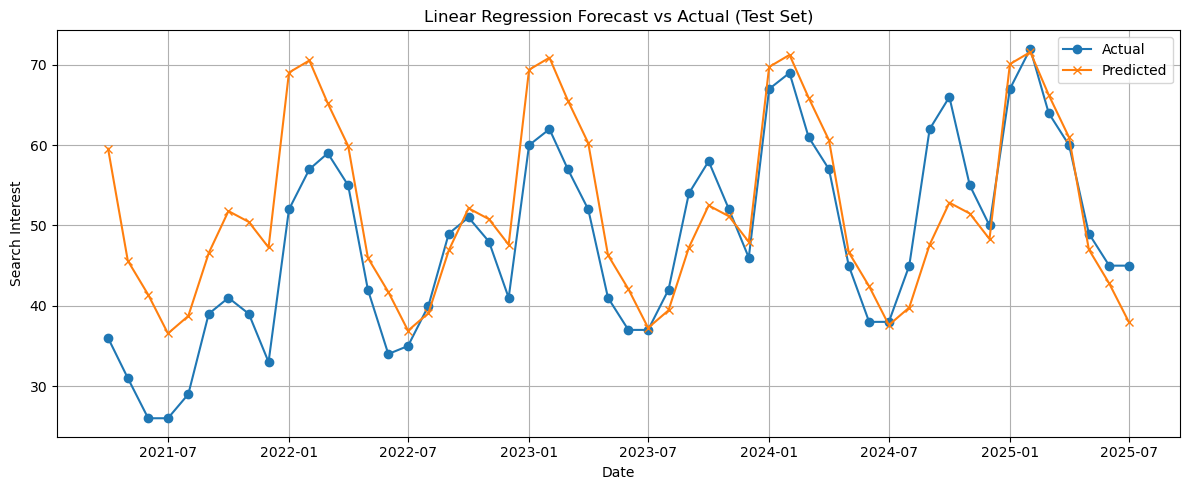

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

df = df_raw.copy()
df['time_idx'] = np.arange(len(df))
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter 

df = pd.get_dummies(df, columns=['month', 'quarter'], drop_first=True)

split_idx = int(len(df) * 0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

X_train = train.drop(columns=['date', 'internship'])
y_train = train['internship']
X_test = test.drop(columns=['date', 'internship'])
y_test = test['internship']

X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')

X_train = X_train.fillna(0)
X_test = X_test.fillna(0)

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Linear Regression MAE on test set: {mae:.3f}")
print(f"Linear Regression RMSE on test set: {rmse:.3f}")

plt.figure(figsize=(12,5))
plt.plot(test['date'], y_test, label='Actual', marker='o')
plt.plot(test['date'], y_pred, label='Predicted', marker='x')
plt.title("Linear Regression Forecast vs Actual (Test Set)")
plt.xlabel("Date")
plt.ylabel("Search Interest")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

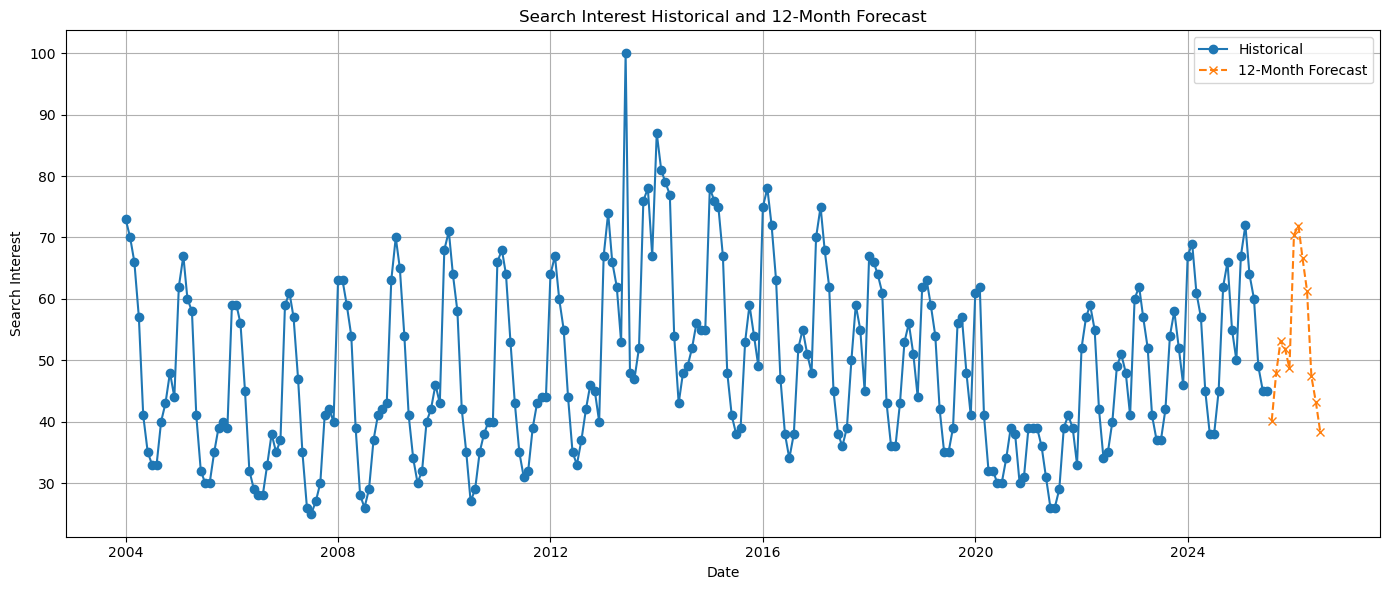

In [15]:
last_date = df['date'].max()
future_dates = pd.date_range(start=last_date + pd.offsets.MonthBegin(1), periods=12, freq='MS')
future_df = pd.DataFrame({'date': future_dates})

future_df['time_idx'] = np.arange(len(df), len(df) + 12)
future_df['month'] = future_df['date'].dt.month
future_df['quarter'] = future_df['date'].dt.quarter

future_df = pd.get_dummies(future_df, columns=['month', 'quarter'])

for col in X_train.columns:
    if col not in future_df.columns:
        future_df[col] = 0

future_X = future_df[X_train.columns]
future_pred = lr.predict(future_X)

plt.figure(figsize=(14,6))
plt.plot(df['date'], df['internship'], label='Historical', marker='o')
plt.plot(future_dates, future_pred, label='12-Month Forecast', marker='x', linestyle='--')
plt.title('Search Interest Historical and 12-Month Forecast')
plt.xlabel('Date')
plt.ylabel('Search Interest')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
r2 = lr.score(X_test, y_test)
print(f"MAPE: {mape:.2f}%")
print(f"Accuracy: {100 - mape:.2f}%")
print(f"R² Score: {r2:.3f}")

MAPE: 14.78%
Accuracy: 85.22%
R² Score: 0.519
